# Import libraries

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform, seed
import pandas as pd
from time import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# 1. (40 pts) Define functions
### Define the following functions

In [13]:
def one_hot_encode(labels):
    """
        Turn single digit numerical value classes into length 10 vectors...
        1 for the positive class and 0's for the other 9 negative classes.
    """
    
    min_l, max_l = min(labels), max(labels)
    one_hot_map = {k: [0 if i < k else 1 if i == k else 0 \
                              for i in range(min_l, max_l+1)] \
                      for k in range(min_l, max_l+1)}
    
    return np.matrix([one_hot_map[label[0]] for label in labels]).reshape(-1, 10)
    
def sigmoid(z):
    """
        Squishes the output of our hypothesis function into the range (0, 1).
    """
       
    clipped = np.clip(z, -500, 500)   # Clip input to sigmoid to prevent overflow
    exp = np.exp(clipped)
    return exp/(exp+1)

def softmax(z):
    """
        Produce confidence probabilities for the output classes.
    """

    clipped = np.clip(z, -500, 500)   # Clip input to sigmoid to prevent overflow
    exp = np.exp(clipped)
    return exp/exp.sum(axis=1).reshape(-1, 1)
    
def log_loss(output, labels):
    """
        Computes the multi-class log loss when provided with the output from the softmax
        group and the corresponding labeled data
    """
    
    output = output.clip(min=1e-5, max=0.99999)
    
    """
    log_output = np.where(output>0, np.log(output), 0)
    log_output_inv = np.where(output<1, np.log(1-output), 0)
    """
    
    return (-1/labels.shape[0]) * np.sum(np.multiply(labels, np.log(output)) + np.multiply((1-labels), np.log(1-output)))
    #return (-1/labels.shape[0]) * np.sum(np.multiply(labels, log_output) + np.multiply((1-labels), log_output_inv))
    
def forward(net, X):
    """
        Perform forward propagation through our neural network. Apply sigmoid to
        the first weighted sum; apply softmax to the second weighted sum.
    """
    
    # Retrieve weights from the network and reinitialize the cached activations
    W1 = net['weights'][0]
    W2 = net['weights'][1]
    net['activations'] = []
           
    # Perform forward pass while appyling bias terms to the input and a1 layers
    X_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)   
    a1 = sigmoid(np.dot(W1, X_bias.T))                              
    a1_bias = np.concatenate((a1, np.ones((1, X.shape[0]))), axis=0) 
    a2 = sigmoid(np.dot(W2, a1_bias)).T    
    
    # Cache input data and activations
    net['input'] = X  
    net['activations'].append(a1)
    net['activations'].append(a2)
                
    return a2
    
def backward(net, labels):
    """
        Perform back propagation through our neural network. Compute error derivatives
        w.r.t. weights.
    """
    
    # Retrieve input data, cached activations, and weights from the network
    X = net['input']
    a1 = net['activations'][0]
    a2 = net['activations'][1]
    W1 = net['weights'][0][:, :-1]
    W2 = net['weights'][1][:, :-1]

    # Compute loss function derivatives w.r.t. parameters and biases
    dL_dW2 = (1/X.shape[0]) * np.dot(a1, (a2-labels)).T
    dL_db2 = (1/X.shape[0]) * np.sum((a2-labels), axis=0, keepdims=True).T
    dL_dW1 = (1/X.shape[0]) * np.dot(np.multiply(np.dot((a2-labels), W2).T, (a1 * (1-a1))), X)
    dL_db1 = (1/X.shape[0]) * np.sum(np.multiply(np.dot((a2-labels), W2).T, (a1 * (1-a1))), axis=1, keepdims=True)   
        
    return dL_dW1, dL_db1, dL_dW2, dL_db2
        
def gradient_descent(net, X, labels, alpha, iters, suppress_output=False):
    """
        Use loss function derivatives w.r.t weights to continually improve the
        performace of our network.
    """
      
    def update_weights(weights, gradients):
        W1, b1 = weights[0][:, :-1], weights[0][:, -1].reshape(-1, 1)
        W2, b2 = weights[1][:, :-1], weights[1][:, -1].reshape(-1, 1)
        
        W1 -= alpha * gradients[0]
        b1 -= alpha * gradients[1]
        W2 -= alpha * gradients[2]
        b2 -= alpha * gradients[3]  
        
    new_cost, old_cost = log_loss(forward(net, X), labels), float('inf')    
    beginning = start = time()
    count = 0
    
    if not suppress_output:
        print('Initial cost:', new_cost)
    
    while count < iters:
        update_weights(net['weights'], backward(net, labels))
        old_cost = new_cost
        new_cost = log_loss(forward(net, X), labels)
        if not suppress_output:
            if time() - start > 10:
                print('\t', new_cost)
            start = time()
        count += 1
            
    elapsed = time() - beginning
    train_eval = old_cost
        
    if not suppress_output:
        print('Model has a log loss of {} -- achieved in {} iterations in {} seconds with a learning rate of {}'.format(
                train_eval, iters, elapsed, alpha))
    
    return (train_eval, elapsed)

# 2. (5 pts) Split data
### Split training and testing data into x and y sets. Input has columns from 0 to 399 and ouput has a column 'y'

In [3]:
train = pd.read_csv('ex3_train.csv')
test = pd.read_csv('ex3_test.csv')

x_train = train.iloc[:, :-1].as_matrix()
x_test = test.iloc[:, :-1].as_matrix()

# One hot encode labels
y_train = one_hot_encode(train.iloc[:, -1].values.reshape(-1, 1))
y_test = one_hot_encode(test.iloc[:, -1].values.reshape(-1, 1))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


# 3. (5 pts) Initialize parameters
### Use np.random.seed(1) when initializing weight coefficients. Set bias terms to 0.

In [16]:
# Form weight matrices by concatenating zeroed bias weights to randomly initialized parameter weights
seed(1); W1_init = np.concatenate((uniform(-1, 1, (25, x_train.shape[1])), np.zeros((25, 1))), axis=1)
seed(1); W2_init = np.concatenate((uniform(-1, 1, (y_train.shape[1], 25)), np.zeros((y_train.shape[1], 1))), axis=1)
W1 = np.copy(W1_init)
W2 = np.copy(W2_init)

# 4. (20 pts) Neural network model with one hidden layer
### Build a neural network model, using the training set, with an input layer of 400 neurons, one hidden layer of 25 neurons, and an output layer of 10 neurons.

In [17]:
net = {'weights': [W1, W2],
       'activations': []
      }

score, elapsed_time = gradient_descent(net, x_train, y_train, alpha=1, iters=100)

Initial cost: 10.86632526
Model has a log loss of 1.2151037946339445 -- achieved in 100 iterations in 2.612070083618164 seconds with a learning rate of 1


# 5. (10 pts) Predictions
### Predict digits using the softmax function. Calculate the accuracy of the predictions using both the training and testing data.

In [18]:
train_max = softmax(forward(net, x_train))
test_max = softmax(forward(net, x_test))

# Apply mask to accentuate softmax output
train_mask = np.where(train_max == train_max.max(axis=1).reshape(-1, 1), 1, 0)
test_mask =  np.where(test_max == test_max.max(axis=1).reshape(-1, 1), 1, 0)

train_score = log_loss(softmax(forward(net, x_train)), y_train)
test_score = log_loss(softmax(forward(net, x_test)), y_test)

print('Training score: {}\nTesting score: {}'.format(train_score, test_score))

Training score: 2.713839379439995
Testing score: 2.723028957799504


# 6. (20 pts) Optimization
### Optimize the model using a variety of learning rates and number of iterations.

In [7]:
scores = []
learning_rates = [10, 1, 0.1]
num_iters = [50, 100, 250, 500, 1000, 5000]

# Train a bunch of models
for a in learning_rates:
    print('Training models with a learning rate of {} for iterations:\n\t'.format(a), end=' ')
    for i in num_iters:
        print(i, end='  ')
        net['weights'][0], net['weights'][1] = np.copy(W1_init), np.copy(W2_init)
        l, t = gradient_descent(net, x_train, y_train, alpha=a, iters=i, suppress_output=True)
        scores.append((l, t, a, i))
    print()

Training models with a learning rate of 10 for iterations:
	 50  100  250  500  1000  5000  
Training models with a learning rate of 1 for iterations:
	 50  100  250  500  1000  5000  
Training models with a learning rate of 0.1 for iterations:
	 50  100  250  500  1000  5000  


### Plot the cost over the number of iterations with different learning rates for the training set.

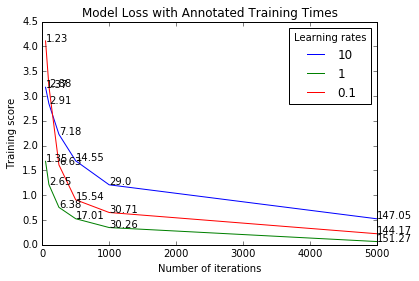

In [8]:
# Organize `loss over # iterations` plot lines for learning rates
data = {
    lr: 
        [s[:2] for s in sorted(
            list(filter(lambda x: x[2] == lr, scores)), key=lambda x: x[3])]
    for lr in learning_rates
}

# Create plot lines for learning rates and annotate with training times
lines = []
for lr, d in data.items():
    evals = [x[0] for x in d]
    times = [x[1] for x in d]
    lines.append(plt.plot(num_iters, [y[0] for y in d], label=str(lr))[0])
    for i, t in enumerate(times):
        plt.annotate(str(round(t, 2)), (num_iters[i], evals[i]))

# Format plot
plt.legend(lines, learning_rates, title='Learning rates')  
plt.xlabel('Number of iterations')
plt.ylabel('Training score')
plt.title('Model Loss with Annotated Training Times')

### Print the optimized accuracy for the test set.

In [15]:
s_max = softmax(forward(net, x_test))

# Apply mask to accentuate softmax output
softmax_mask = np.where(s_max == s_max.max(axis=1).reshape(-1, 1), 1, 0)

print('\nSoftmax: {}'.format(log_loss(softmax_mask, y_test)))


Softmax: 2.3487347553441937
